# Problem 1: Importance Sampling

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Fit a model to the data using:
a. Uniform priors on all parameters
b. Modestly informative Gaussian priors on all parameters
c. Strongly informative Gaussian priors on all parameters

Draw samples from the posterior using any sampler of your choosing.

After sampling in cases (b) and (c), calculate importance weights and resample your posteriors in order to "undo" the informative prior. This step will create a vector of unweighted posterior samples from your original vector of weighted posterior samples. Verify that after importance sampling your results are equivalent to what you obtained in case (a).

Examine the posterior distributions. Do you see any numerical noise or other sampling artifacts introduced by importance sampling?

In [4]:
%pip install pymc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.7/473.7 kB 6.7 MB/s eta 0:00:00a 0:00:01
  Using cached fastprogress-1.0.3-py3-none-any.whl (12 kB)
  Using cached arviz-0.17.1-py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:0000:0100:01m
  Using cached h5netcdf-1.6.1-py3-none-any.whl (49 kB)
  Using cached xarray_einstats-0.7.0-py3-none-any.whl (31 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9100 sha256=7575b68236454e2f985732a6ed666977fbde7f28502eca1afcfff72ca3efd449
  Stored in directory: /Users/ananaysethi/Library/Caches/pip/wheels/56/8e/eb/130d313bbaf36c97915634104d81fb7119332331ce32dca02e
  Created wheel for logical-unification: filename=logical_unification-0.4.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pymc as pm
# import pymc3_ext as pmx

import emcee
import corner

In [7]:
tb = pd.read_csv('line_fitting.csv')
tb.head()

,Unnamed: 0,x,y,y_err
0,0,0.596779,8.112571,0.160314
1,1,0.921049,3.528151,0.513170
2,2,1.156184,4.810234,0.401530
3,3,1.754518,0.892382,0.372534
4,4,1.824917,3.132952,0.271382


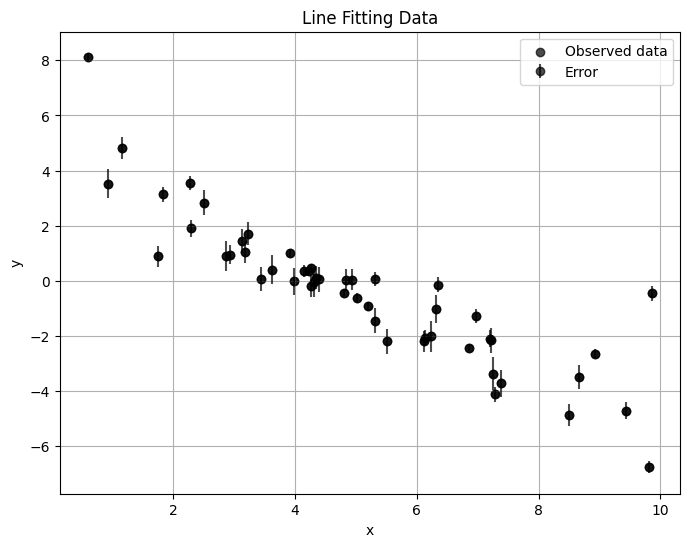

In [8]:
x_err = np.zeros(len(tb['y_err']))

plt.figure(figsize=(8, 6))
plt.scatter(tb['x'], tb['y'], color='black', alpha=0.7, label='Observed data')
plt.errorbar(tb['x'], tb['y'], yerr = tb['y_err'], fmt='o', color='black', alpha=0.7, label='Error')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Line Fitting Data')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Load data
data = pd.read_csv("line_fitting.csv")
x = data['x'].values
y = data['y'].values
yerr = data['y_err'].values

# Model
def model(theta, x):
    m, b = theta
    return m * x + b

# Likelihood
def log_likelihood(theta, x, y, yerr):
    y_model = model(theta, x)
    return -0.5 * np.sum(((y - y_model) / yerr) ** 2 + np.log(2 * np.pi * yerr ** 2))

# Priors
def log_prior_uniform(theta):
    m, b = theta
    if -10 < m < 10 and -10 < b < 10:
        return 0.0
    return -np.inf

def log_prior_modest(theta):
    m, b = theta
    return -0.5 * (m**2 / 5**2 + b**2 / 5**2)

def log_prior_strong(theta):
    m, b = theta
    return -0.5 * (m**2 / 1**2 + b**2 / 1**2)

# Posterior
def log_posterior(theta, x, y, yerr, prior):
    if prior == 'uniform':
        lp = log_prior_uniform(theta)
    elif prior == 'modest':
        lp = log_prior_modest(theta)
    elif prior == 'strong':
        lp = log_prior_strong(theta)
    else:
        raise ValueError("Invalid prior type.")
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [20]:
# Run emcee
def run_sampler(prior_type):
    ndim, nwalkers, nsteps = 2, 50, 5000
    initial = np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, yerr, prior_type))
    sampler.run_mcmc(initial, nsteps, progress=True)
    return sampler

sampler_uniform = run_sampler("uniform")
sampler_modest = run_sampler("modest")
sampler_strong = run_sampler("strong")

# Get samples after burn-in
burn = 1000
samples_uniform = sampler_uniform.get_chain(discard=burn, flat=True)
samples_modest = sampler_modest.get_chain(discard=burn, flat=True)
samples_strong = sampler_strong.get_chain(discard=burn, flat=True)

# Importance sampling to undo prior
def importance_weights(samples, prior_from, prior_to):
    if prior_from == "modest":
        logp_from = -0.5 * np.sum(samples**2 / 25, axis=1)
    elif prior_from == "strong":
        logp_from = -0.5 * np.sum(samples**2 / 1, axis=1)
    else:
        raise ValueError("Invalid source prior")
    
    logp_to = np.zeros(len(samples))  # uniform: log(1)

    weights = np.exp(logp_to - logp_from)
    weights /= np.sum(weights)  # normalize
    return weights

# Resample based on weights
def resample(samples, weights, n_samples=10000):
    idx = np.random.choice(np.arange(len(samples)), size=n_samples, p=weights)
    return samples[idx]

weights_modest = importance_weights(samples_modest, "modest", "uniform")
weights_strong = importance_weights(samples_strong, "strong", "uniform")

resampled_modest = resample(samples_modest, weights_modest)
resampled_strong = resample(samples_strong, weights_strong)

100%|██████████| 5000/5000 [00:06<00:00, 801.59it/s]


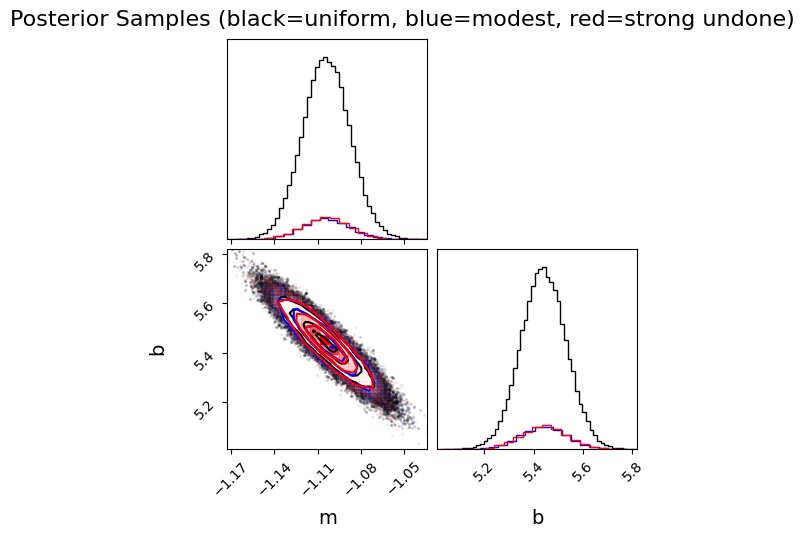

In [21]:
# Plot comparison
fig = corner.corner(samples_uniform, labels=["m", "b"], color='black', bins=50, label_kwargs={'fontsize':14}, title_fmt=".2f")
corner.corner(resampled_modest, labels=["m", "b"], color='blue', fig=fig)
corner.corner(resampled_strong, labels=["m", "b"], color='red', fig=fig)
plt.suptitle("Posterior Samples (black=uniform, blue=modest, red=strong undone)", fontsize=16)
plt.show()

# Problem 2: Umbrella Sampling Tutorial

Work through the umbrella sampling tutorial here: https://gjgilbert.github.io/tutorials/umbrella_sampling/

Once you complete the tutorial, return to the Line Fitting dataset from Problem 1. Fit a model using umbrella sampling. You'll need to choose how to define your umbrella windows and biases - there are many possible solutions! After sampling from individual umbrellas, combine your samples into a single set of posterior samples. Verify that the results you obtain from umbrella sampling are equivalent to the results you obtain from other methods.

In [23]:
import numpy.polynomial.polynomial as poly

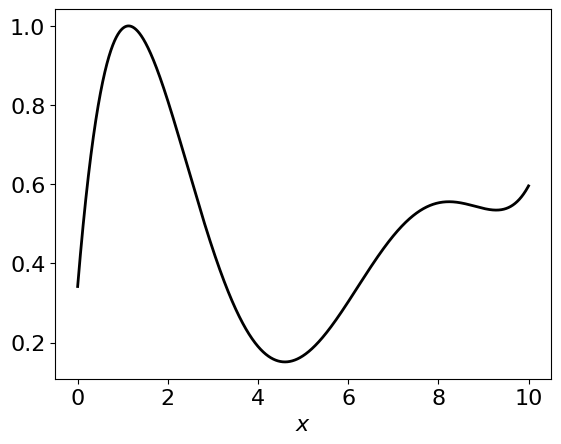

In [24]:
# set the seed for reproducibility
np.random.seed(234)

# generate a random polynomial
xpts = np.random.uniform(0,10, size=6)
ypts = np.random.uniform(3,6, size=6)
pfit = poly.polyfit(xpts,ypts,5)

# here's the simulated probability density function (pdf)
Npdf = int(1e6)
x_pdf = np.linspace(0,10,Npdf)
y_pdf = poly.polyval(x_pdf, pfit)
y_pdf = y_pdf/(np.sum(y_pdf)/Npdf*(x_pdf.max()-x_pdf.min()))

plt.figure()
plt.rc("font", size=16)
plt.plot(x_pdf, y_pdf/y_pdf.max(), c="k", lw=2)
plt.xlabel(r"$x$")
plt.show()

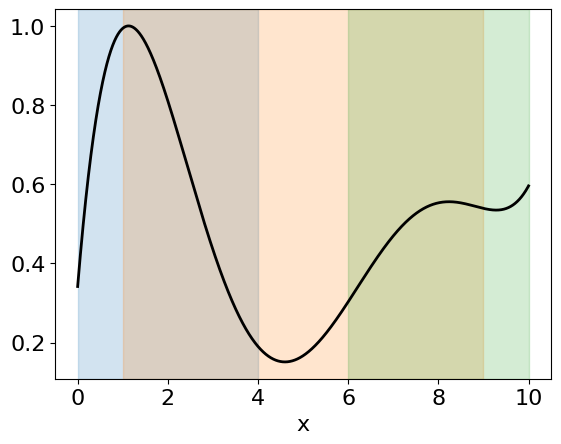

In [25]:
plt.figure()
plt.rc("font", size=16)
plt.plot(x_pdf, y_pdf/y_pdf.max(), c="k", lw=2)
plt.axvspan(0, 4, color="C0", alpha=0.2)
plt.axvspan(1, 9, color="C1", alpha=0.2)
plt.axvspan(6, 10, color="C2", alpha=0.2)
plt.xlabel("x")
plt.show()

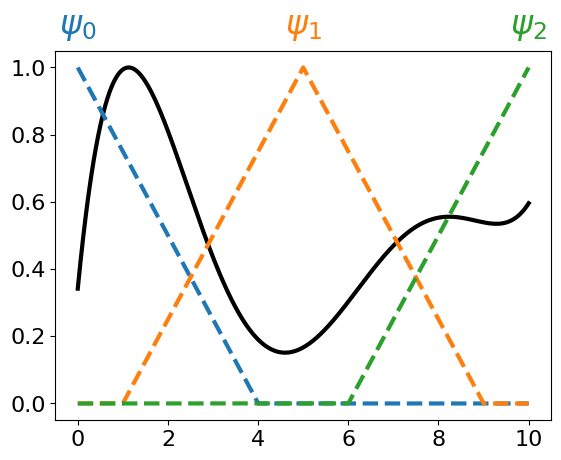

In [26]:
import scipy.stats as stats

def psi_0(x):
    return 2*stats.triang(c=0.5, loc=-4, scale=8).pdf(x)

def psi_1(x):
    return stats.triang(c=0.5, loc=1, scale=8).pdf(x)

def psi_2(x):
    return 2*stats.triang(c=0.5, loc=6, scale=8).pdf(x)


psi_fxns = [psi_0, psi_1, psi_2]
Nwin = len(psi_fxns)

plt.figure()
plt.rc("font", size=16)
plt.plot(x_pdf, y_pdf/y_pdf.max(), c="k", lw=3)
for i in range(Nwin):
    plt.plot(x_pdf, psi_fxns[i](x_pdf)/np.max(psi_fxns[i](x_pdf)), lw=3, ls="--")    
    plt.text(5*i, 1.1, r"$\psi_{0}$".format(i), color="C{0}".format(i), fontsize=24, ha="center")
plt.savefig("umbrella_small.png")
plt.show()

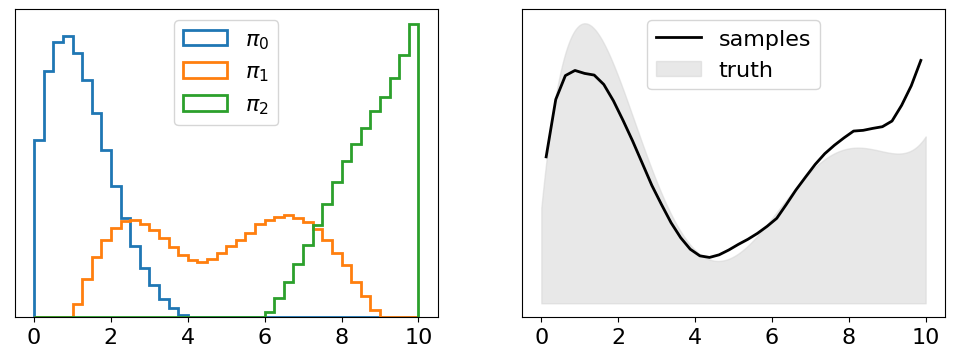

In [28]:
# draw samples from each window
Nsamp = Npdf//2
samples = np.zeros((Nwin,Nsamp))

for i, psi in enumerate(psi_fxns):
    prob = psi(x_pdf)*y_pdf
    prob /= np.sum(prob)
    
    samples[i] = np.random.choice(x_pdf, p=prob, size=Nsamp)
    

# make plots
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.rc("font", size=16)
bins = np.linspace(0,10,41)

for i, samp in enumerate(samples):
    ax[0].hist(samp, bins=bins, density=True, histtype="step", lw=2, label=r"$\pi_{0}$".format(i))
    ax[0].set_yticks([])
    ax[0].legend(loc="upper center")
    
y, x = np.histogram(np.hstack(samples), bins=bins, density=True)
x = 0.5*(x[1:]+x[:-1])

ax[1].plot(x, y, lw=2, color="k", label="samples")
plt.fill_between(x_pdf, y_pdf, color="lightgrey", alpha=0.5, label="truth") 
ax[1].legend(loc="upper center")
ax[1].set_yticks([])

plt.show()

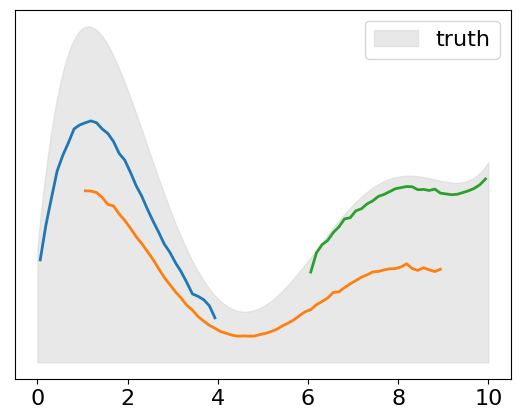

In [29]:
plt.figure()
plt.rc("font", size=16)
bins = np.linspace(0,10,81)

# weights for each window removing bias
for i, psi in enumerate(psi_fxns):
    w = 1/psi(samples[i])
    w /= np.sum(w)
    
    y, x = np.histogram(samples[i], bins=bins, weights=w)
    x = 0.5*(x[1:]+x[:-1])
    
    plt.plot(x[y>0], y[y>0], lw=2)

# ground truth renormalized for visualization
plt.fill_between(x_pdf, y_pdf/3, color="lightgrey", alpha=0.5, label="truth") 
plt.legend(loc="upper right")
plt.yticks([])
plt.show()

In [35]:
Phi = np.zeros((3,2))

for i, psi in enumerate(psi_fxns):
    w = 1/psi(samples[i])
    w /= np.sum(w)
    
    y, x = np.histogram(samples[i], bins=[0,1,4,6,9,10], weights=w)
        
    Phi[i,0] = np.mean(y[1])
    Phi[i,1] = np.mean(y[3])

print('Phi =\n ', '\n'.join(['\t'.join([str(cell) for cell in row]) for row in Phi.round(2)]))

Phi =
  0.71	0.0
0.5	0.39
0.0	0.73


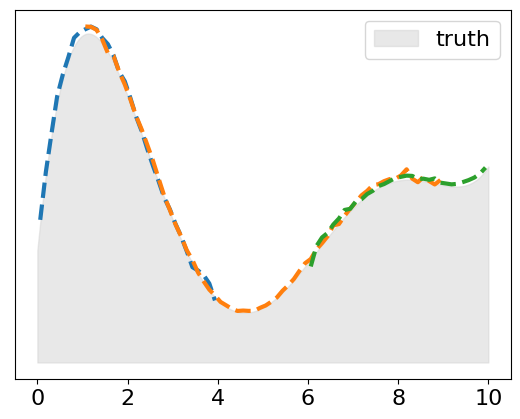

In [36]:
z_wham = np.array([Phi[0,0]/Phi[1,0], 1.0, Phi[2,1]/Phi[1,1]])

plt.figure()
plt.rc("font", size=16)
bins = np.linspace(0,10,81)

for i, psi in enumerate(psi_fxns):
    w = 1/psi(samples[i])
    w /= np.sum(w)
    
    y, x = np.histogram(samples[i], bins=bins, weights=w)
    x = 0.5*(x[1:]+x[:-1])
    
    plt.plot(x[y>0], y[y>0]/z_wham[i], lw=3, ls="--")

# ground truth renormalized for visualization
plt.fill_between(x_pdf, y_pdf/6, color="lightgrey", alpha=0.5, label="truth")
plt.yticks([])
plt.legend(loc="upper right")
plt.show()

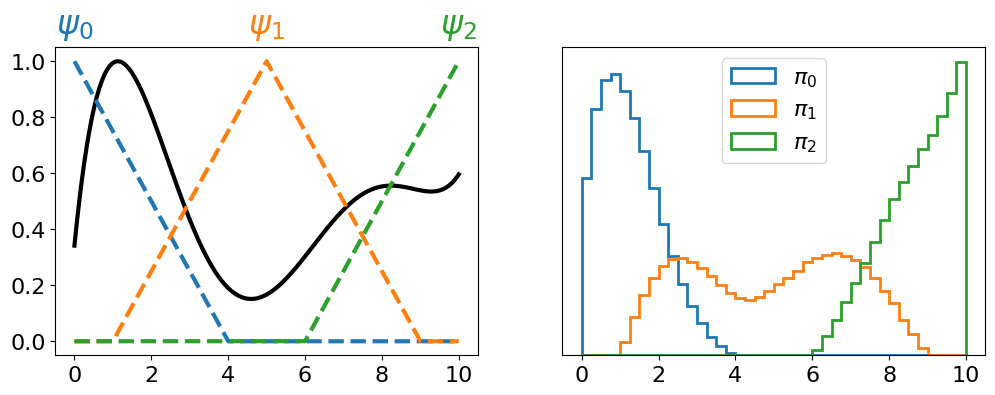

In [37]:
# make plots
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.rc("font", size=16)
bins = np.linspace(0,10,41)

ax[0].plot(x_pdf, y_pdf/y_pdf.max(), c="k", lw=3)

for i in range(Nwin):
    ax[0].plot(x_pdf, psi_fxns[i](x_pdf)/np.max(psi_fxns[i](x_pdf)), lw=3, ls="--")    
    ax[0].text(5*i, 1.1, r"$\psi_{0}$".format(i), color="C{0}".format(i), fontsize=24, ha="center")

    ax[1].hist(samples[i], bins=bins, density=True, histtype="step", lw=2, label=r"$\pi_{0}$".format(i))
    ax[1].set_yticks([])
    ax[1].legend(loc="upper center")

plt.savefig("umbrella.png")
plt.show()

In [38]:
from scipy import linalg

# Equation (4)
def F_iter(psi_fxns, samples, z):
    Nwin = len(psi_fxns)
    F = np.zeros((Nwin,Nwin))
    
    for i in range(Nwin):

        denom = 0.
        for k in range(Nwin):
            denom += psi_fxns[k](samples[i])/z[k]

        for j in range(Nwin):
            num = psi_fxns[j](samples[i])/z[i]

            F[i,j] = np.mean(num/denom)
            
    return F


# Equation (7)
def z_iter(F, tol=1.E-10, max_iter=100):   
    
    # stationary distribution is the last column of QR factorization
    # this solves for the eigenvector
    M = np.eye(len(F))-F
    q,r = linalg.qr(M)
    z = q[:,-1] 
    z /= np.sum(z)
    
    # polish solution using power method
    # this isolates the largest (aka dominant) eigenvalue
    for itr in range(max_iter):
        znew = np.dot(z,F)
        tv = np.abs(znew[z > 0] - z[z > 0]) 
        tv = tv/z[z > 0]
        
        maxresid = np.max(tv) 
        if maxresid < tol:
            break
        else:
            z = znew
            
    # return normalized (by convention)
    return z/np.sum(z)

In [39]:
z = np.zeros(Nwin)

for i, psi in enumerate(psi_fxns):
    z[i] = np.mean(psi(samples[i]))
    
z /= np.sum(z)

print("Starting estimate for z:", z.round(4))

Starting estimate for z: [0.4188 0.1671 0.4141]


In [40]:
# first iteration of Eq. 4 & 7
F = F_iter(psi_fxns, samples, z)
z = z_iter(F)

print("\n\nITERATION 1")
print("\n F\n--\n\n", F.round(4))
print("\n z\n--\n", z.round(4))

# iterate until convergence
for n in range(100):
    # for numerical stability
    z_old = np.copy(z)
    z_old[z_old < 1e-100] = 1e-100

    # Eq. 4 & 7 again
    F = F_iter(psi_fxns, samples, z)
    z = z_iter(F)

    # check if we have converged
    if np.max(np.abs(z-z_old)/z_old) < 1e-10:
        break
        
        
print("\n\nITERATION {0}".format(n+1))
print("\n F\n--\n\n", F.round(4))
print("\n z\n--\n", z.round(4))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


ITERATION 1

 F
--

 [[0.8285 0.0684 0.    ]
 [0.3899 0.7194 0.3098]
 [0.     0.0789 0.8045]]

 z
--
 [0.4679 0.2058 0.3263]


ITERATION 4

 F
--

 [[0.8375 0.0715 0.    ]
 [0.3694 0.6829 0.2449]
 [0.     0.0976 0.8454]]

 z
--
 [0.468  0.2059 0.3261]


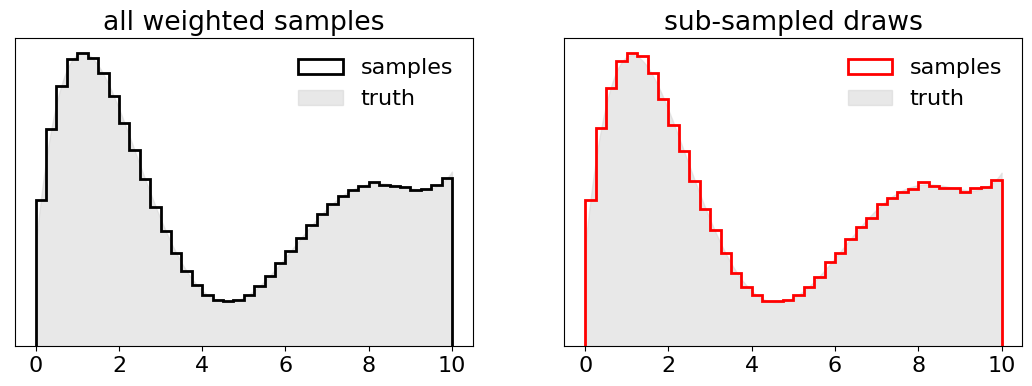

In [41]:
weights = []
for i in range(Nwin):
    
    # compute weights as in eq 4 in Matthews et al. 
    wd = 0.
    for k in range(Nwin):
        wd += psi_fxns[k](samples[i])/z[k]

    weights.append(1./wd)
weights = np.array(weights).flatten()

sub_samples = np.random.choice(np.array(samples).flatten(), p=weights/np.sum(weights), size=Nsamp)


# histogram using all weighted samples
fig, ax = plt.subplots(1,2, figsize=(13,4))

ax[0].hist(np.array(samples).flatten(), weights=weights, bins=bins, histtype="step", density=True, lw=2, color="k", label='samples')
ax[0].fill_between(x_pdf, y_pdf, label='truth', color='lightgrey', alpha=0.5)
ax[0].set_yticks([])
ax[0].legend(frameon=False, loc='upper right')
ax[0].set_title("all weighted samples")

# histogram using sub-samples
ax[1].hist(sub_samples, bins=bins, histtype="step", density=True, lw=2, color="r", label='samples')
ax[1].fill_between(x_pdf, y_pdf, label='truth', color='lightgrey', alpha=0.5)
ax[1].set_yticks([])
ax[1].legend(frameon=False, loc='upper right')
ax[1].set_title("sub-sampled draws")

plt.show()

# Problem 3: Reparameterizing a Model

Read in the Two Component Sinusoid dataset (two_component_sinusoid.csv) and plot the data.

Fit a model using the most "obvious" parameterization:

$y(x) = A_1 \sin(2\pi f_1 x - \phi_1 + A_2 \sin(2\pi f_2 x - \phi_2)$

Place appropriate independent priors on each of the six free parameters. Try fitting a model, drawing samples using a sampler of your choosing. Check for convergence and assess the quality of your results. Re-run your model a few times and check if your results remain consistent from run-to-run.

You will probably not acheive a very good fit using this parameterization. Why is this parameterization problematic? Re-parameterize the model in order to get a more robust fit. Check for convergence and that your posteriors remain consistent from run-to-run.